# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density

def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

/Users/jhkwakkel/Documents/workspace/EMAworkbench/ema_workbench/connectors/__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME'),
            TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]


#Define the Python model
py_model = Model('Python', function=PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

#Define the NetLogo model
nl_model = NetLogoModel('NetLogo', wd='./model/', model_file="PredPrey.nlogo")
nl_model.run_length = int(365 / 0.25)
nl_model.replications = 1
nl_model.uncertainties = uncertainties
nl_model.outcomes = outcomes

#Define the Excel model
excel_model = ExcelModel('Excel', wd='./model/', model_file='PredPrey.xlsx')
excel_model.sheet = 'Sheet1'
excel_model.uncertainties = uncertainties
excel_model.outcomes = outcomes

#Define the PySD (Vensim) model
pysd_model = PysdModel('PySD', mdl_file='./model/PredPrey.mdl')
pysd_model.uncertainties = uncertainties
pysd_model.outcomes = outcomes
    
nr_experiments = 50
#Using Latin Hypercube sampling
results_lhs = perform_experiments([py_model, nl_model, excel_model, pysd_model],
                                  nr_experiments, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 4 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


We can split the results tuple into experiments and outcomes, and check the dimensions of each. The dimensions of each outcome array correspond to 200 experiments (50 unique combinations of uncertainties * 4 models), 1 replication, and 1461 time steps (or 365/0.25).

In [4]:
exp, out = results_lhs
print(exp.shape)
print(out['prey'].shape)

#The experiments are grouped sequentially by model: indices 0-49 are the Python function, 50-99 the NetLogo model, etc.
print(exp[0])
print(exp[50])
print(exp[100])

(200,)
(200, 1, 1461)
( 0.00178982,  0.00102046,  0.07581744,  0.02390736, 50, 'None', 'Python')
( 0.00178982,  0.00102046,  0.07581744,  0.02390736, 50, 'None', 'NetLogo')
( 0.00178982,  0.00102046,  0.07581744,  0.02390736, 50, 'None', 'Excel')


In [5]:
out_rep0 = {key:out[key][:,0,:] for key in out.keys()}
results_rep0 = (exp.copy(), out_rep0)
print(out_rep0['TIME'].shape)

(200, 1461)


The lines graph shows that although the models behave quite differently depending on the experiments, the results are graphically identical across the 4 models.

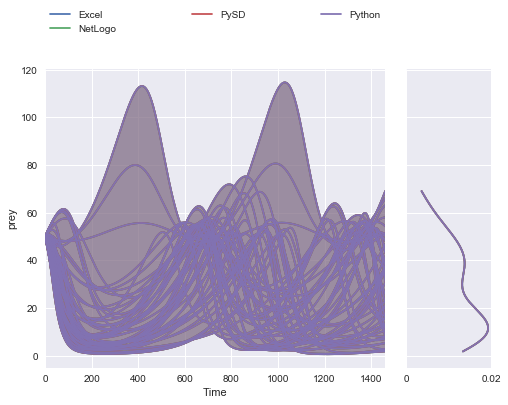

In [9]:
lines(results_rep0, outcomes_to_show='prey', group_by='model',
      show_envelope=True, density=Density.KDE, titles=None, 
      experiments_to_show=np.arange(0, len(exp), 1)
      )
plt.show()

Finally, we can check any differences between the model implementations and the Python function, by using logical indexing to select the outcome indices corresponding to each model, and subtracting the arrays from each other:

In [7]:
#Find the model implementations that were sampled in the experiments
models = [i for i in np.unique(exp['model']) if i != 'Python']

for model in models:
    print('Max absolute error with {}:'.format(model))
    print(np.max(abs(out_rep0['prey'][exp['model']=='Python'] - out_rep0['prey'][exp['model']==model])))

Max absolute error with Excel:
3.5527136788e-15
Max absolute error with NetLogo:
6.67910171614e-13
Max absolute error with PySD:
4.47641923529e-13
